In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large   # or MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)


In [4]:
TRAIN_DIR = "/content/drive/MyDrive/new work/Dataset/train"
VAL_DIR   = "/content/drive/MyDrive/new work/Dataset/train"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20

In [5]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.10,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train_it = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=SEED
)

val_it = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_it.class_indices.keys())
num_classes = len(class_names)

print("\nClass indices:", train_it.class_indices)
print("Class names:", class_names)

Found 7597 images belonging to 4 classes.
Found 7597 images belonging to 4 classes.

Class indices: {'Hyperpigmentation': 0, 'Nail fungus': 1, 'clubbing': 2, 'normal': 3}
Class names: ['Hyperpigmentation', 'Nail fungus', 'clubbing', 'normal']


In [6]:
batchX, batchy = next(train_it)
print(f"\nBatch X shape: {batchX.shape}, y shape: {batchy.shape}")
print(f"Batch min/max: {batchX.min():.3f}, {batchX.max():.3f}")


Batch X shape: (32, 224, 224, 3), y shape: (32, 4)
Batch min/max: 0.000, 255.000


In [7]:
backbone = MobileNetV3Large(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)

# Stage 1: freeze backbone
backbone.trainable = False

x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.30)(x)
outputs = Dense(num_classes, activation="softmax")(x)

model = Model(inputs=backbone.input, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [8]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint("best_mobilenetv3.keras", monitor="val_loss", save_best_only=True),
]

In [9]:
history1 = model.fit(
    train_it,
    validation_data=val_it,
    epochs=EPOCHS,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 2541s 11s/step - accuracy: 0.5860 - loss: 1.0560 - val_accuracy: 0.9127 - val_loss: 0.3173 - learning_rate: 0.0010
Epoch 2/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 596ms/step - accuracy: 0.8777 - loss: 0.3570 - val_accuracy: 0.9551 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 3/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 584ms/step - accuracy: 0.9078 - loss: 0.2593 - val_accuracy: 0.9655 - val_loss: 0.1620 - learning_rate: 0.0010
Epoch 4/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 137s 577ms/step - accuracy: 0.9301 - loss: 0.2237 - val_accuracy: 0.9695 - val_loss: 0.1347 - learning_rate: 0.0010
Epoch 5/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 584ms/step - accuracy: 0.9431 - loss: 0.1886 - val_accuracy: 0.9741 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 6/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 137s 575ms/step - accuracy: 0.9435 - loss: 0.1764 - val_accuracy: 0.9738 - val_loss: 0.1179 - learning_rate: 0.0010
Epoch 7/20
238/238 ━━━━━━━━━━━━━━━━━━━━ 137s 577ms/step - accurac

In [10]:
FINE_TUNE = True
if FINE_TUNE:
    backbone.trainable = True

    # Freeze earlier layers, fine-tune only last N layers
    N_UNFROZEN = 40
    for layer in backbone.layers[:-N_UNFROZEN]:
        layer.trainable = False

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    history2 = model.fit(
        train_it,
        validation_data=val_it,
        epochs=10,
        callbacks=callbacks
    )
else:
    history2 = None

Epoch 1/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 174s 653ms/step - accuracy: 0.8238 - loss: 0.6664 - val_accuracy: 0.9812 - val_loss: 0.0709 - learning_rate: 1.0000e-05
Epoch 2/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 581ms/step - accuracy: 0.9027 - loss: 0.3073 - val_accuracy: 0.9835 - val_loss: 0.0632 - learning_rate: 1.0000e-05
Epoch 3/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 579ms/step - accuracy: 0.9363 - loss: 0.1874 - val_accuracy: 0.9842 - val_loss: 0.0555 - learning_rate: 1.0000e-05
Epoch 4/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 581ms/step - accuracy: 0.9499 - loss: 0.1428 - val_accuracy: 0.9858 - val_loss: 0.0486 - learning_rate: 1.0000e-05
Epoch 5/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 150s 630ms/step - accuracy: 0.9620 - loss: 0.1110 - val_accuracy: 0.9888 - val_loss: 0.0405 - learning_rate: 1.0000e-05
Epoch 6/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 137s 575ms/step - accuracy: 0.9689 - loss: 0.0979 - val_accuracy: 0.9912 - val_loss: 0.0359 - learning_rate: 1.0000e-05
Epoch 7/10
238/238 ━━━━━━━━━━━━━━━━━━━━ 

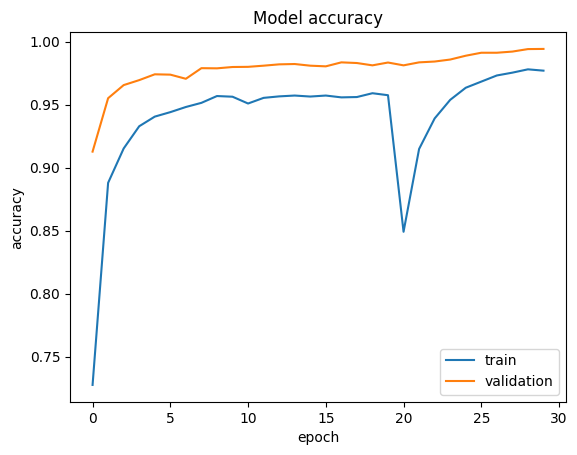

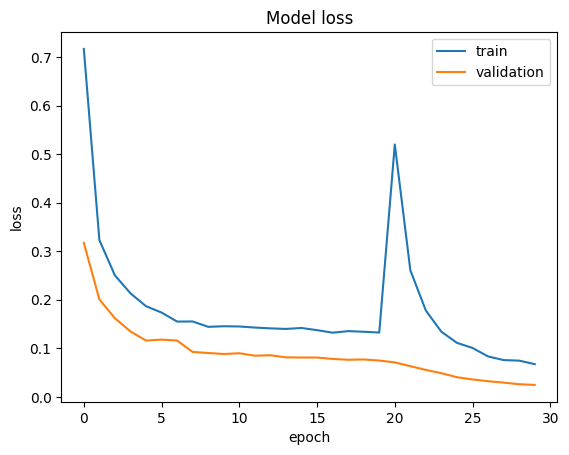

In [11]:

def merge_histories(h1, h2):
    out = dict(h1.history)
    if h2 is None:
        return out
    for k in out.keys():
        out[k] = h1.history[k] + h2.history.get(k, [])
    return out

hist = merge_histories(history1, history2)

plt.figure()
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="lower right")
plt.show()

plt.figure()
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()


238/238 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step


<Figure size 640x480 with 0 Axes>

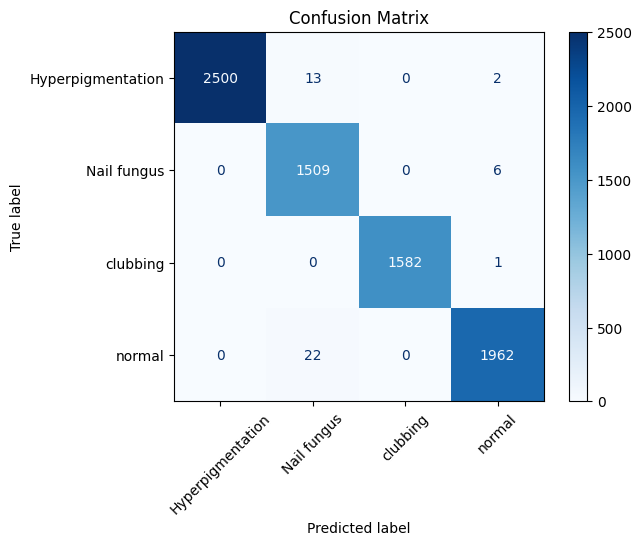


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       1.00      0.99      1.00      2515
      Nail fungus       0.98      1.00      0.99      1515
         clubbing       1.00      1.00      1.00      1583
           normal       1.00      0.99      0.99      1984

         accuracy                           0.99      7597
        macro avg       0.99      0.99      0.99      7597
     weighted avg       0.99      0.99      0.99      7597


Final Validation Accuracy: 0.9942
Final Validation Loss:     0.0245


In [12]:
val_it.reset()
Y_pred = model.predict(val_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_it.classes

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure()
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

val_loss, val_acc = model.evaluate(val_it, verbose=0)
print(f"\nFinal Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss:     {val_loss:.4f}")

238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 135ms/step


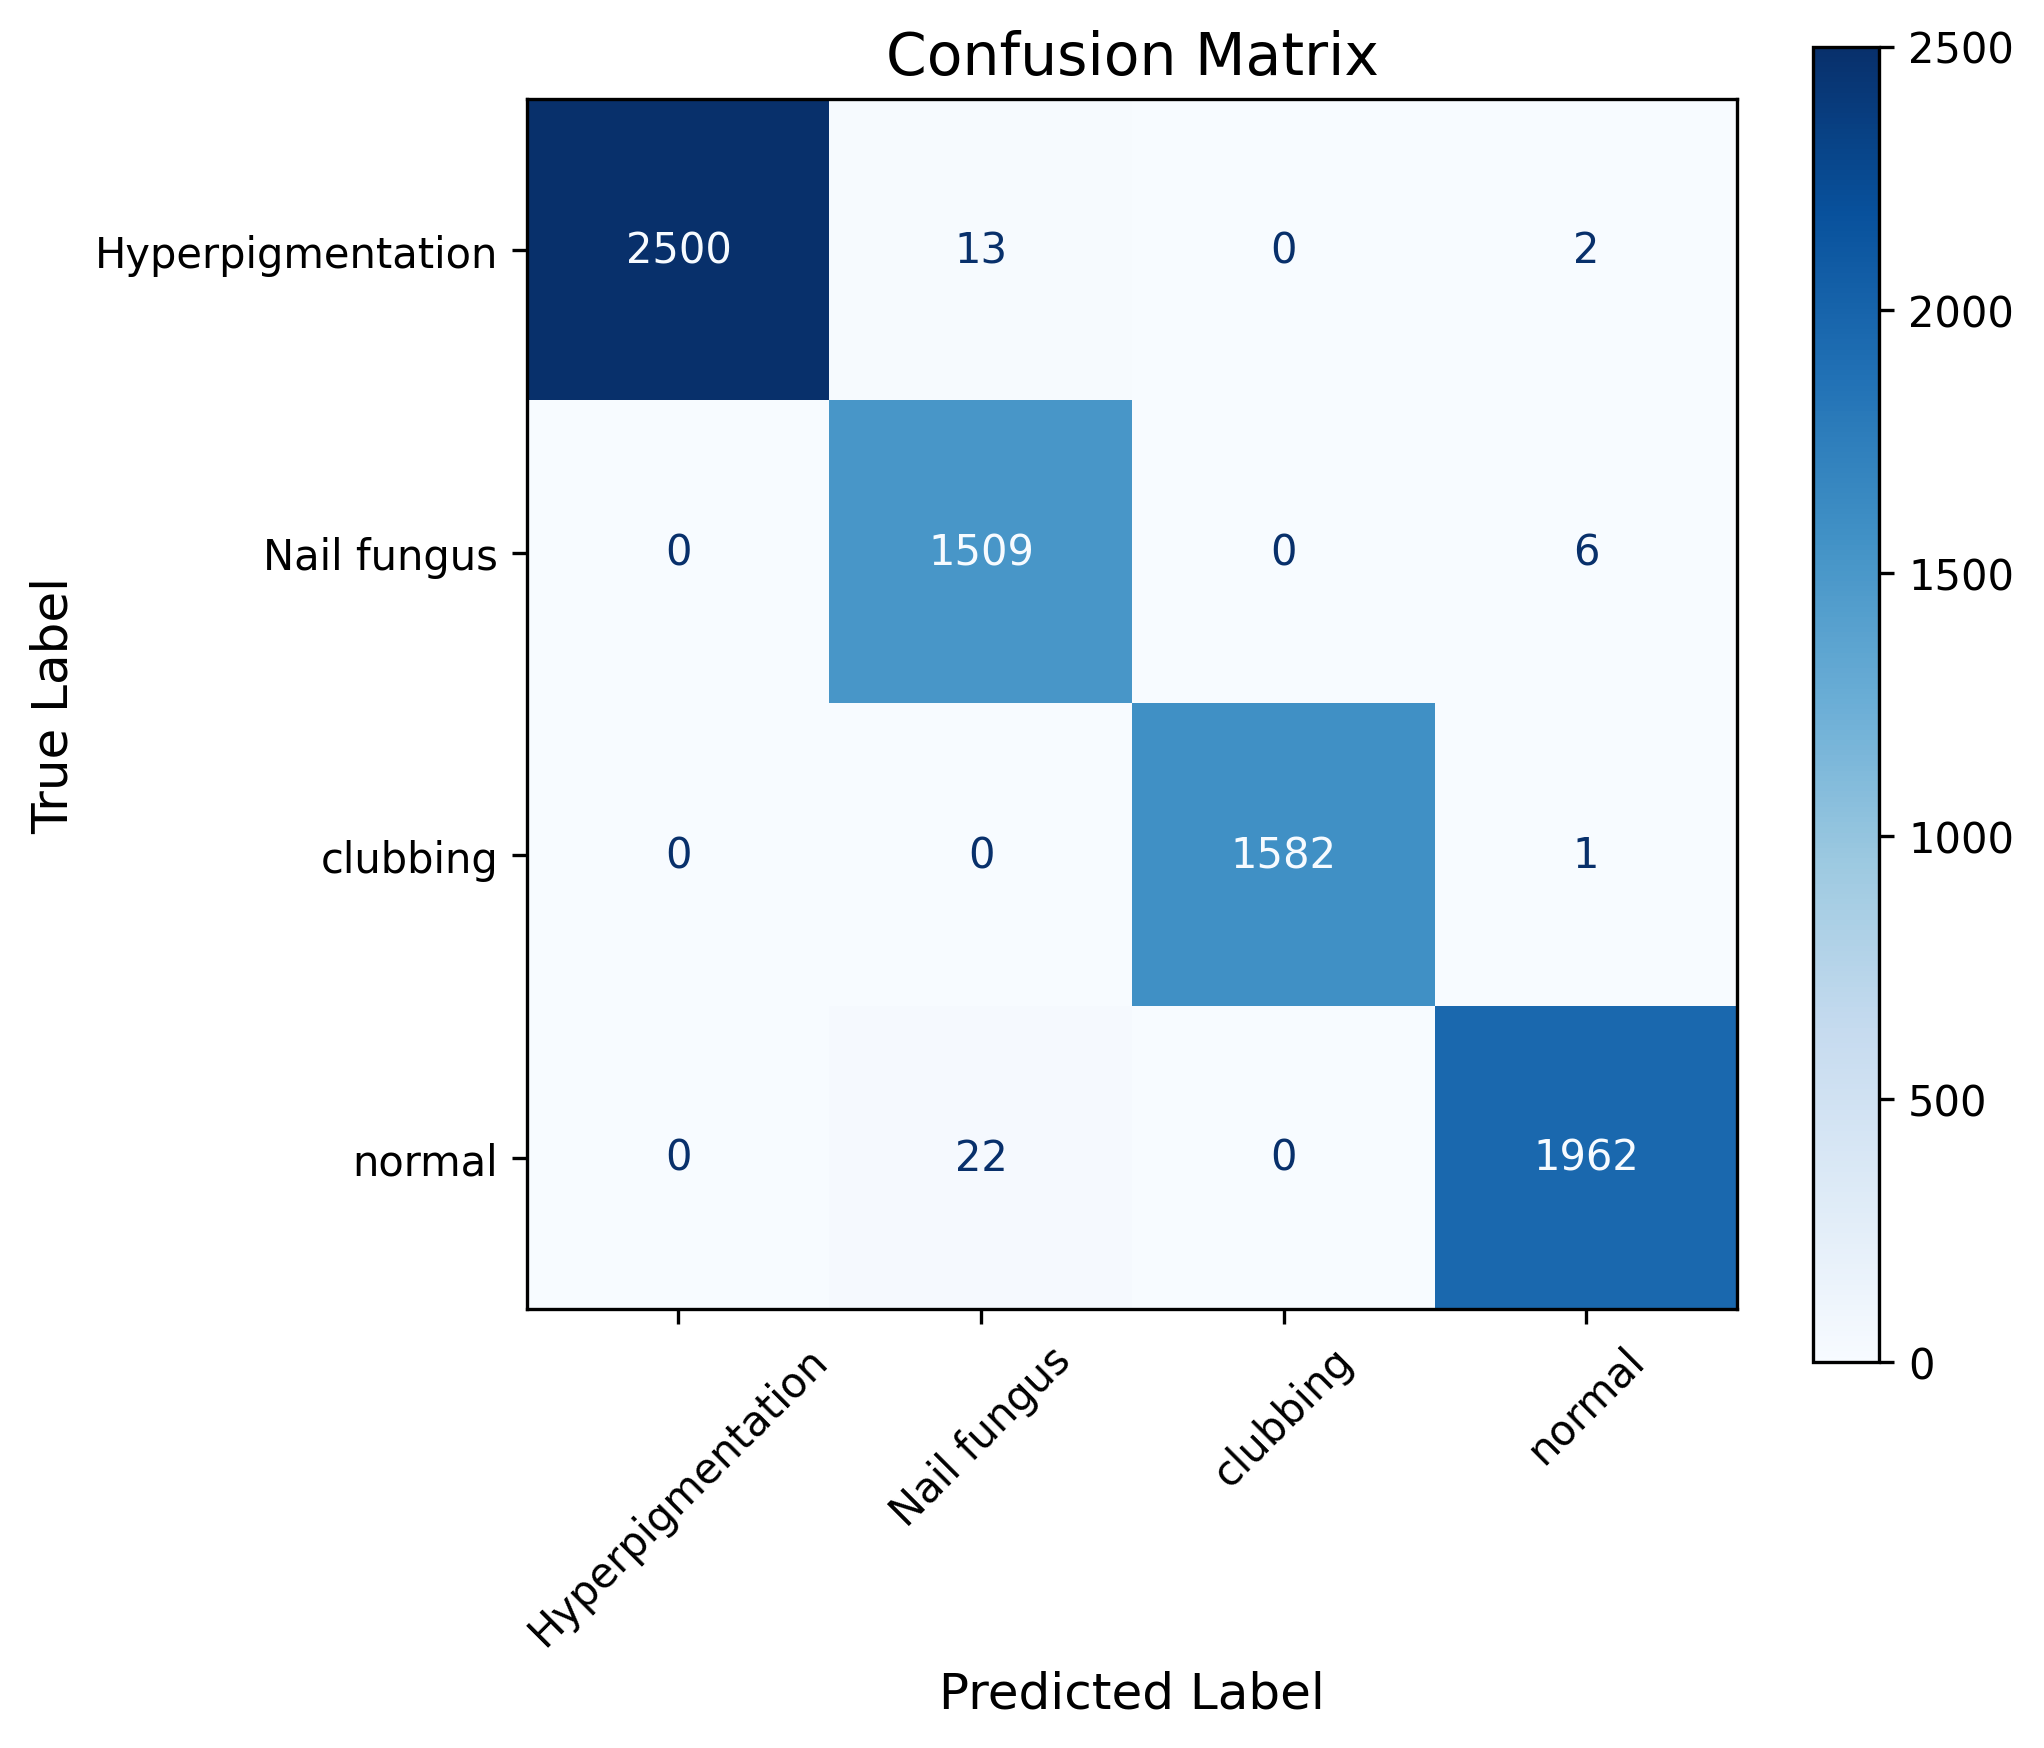


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation     1.0000    0.9940    0.9970      2515
      Nail fungus     0.9773    0.9960    0.9866      1515
         clubbing     1.0000    0.9994    0.9997      1583
           normal     0.9954    0.9889    0.9922      1984

         accuracy                         0.9942      7597
        macro avg     0.9932    0.9946    0.9939      7597
     weighted avg     0.9943    0.9942    0.9942      7597


Classification Report:

                   precision    recall  f1-score   support

Hyperpigmentation       1.00      0.99      1.00      2515
      Nail fungus       0.98      1.00      0.99      1515
         clubbing       1.00      1.00      1.00      1583
           normal       1.00      0.99      0.99      1984

         accuracy                           0.99      7597
        macro avg       0.99      0.99      0.99      7597
     weighted avg       0.99      0.99      0.99      7597



In [13]:
# Reset generator
val_it.reset()

# Predictions
Y_pred = model.predict(val_it, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_it.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# High-quality figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    ax=ax,
    cmap="Blues",
    xticks_rotation=45,
    colorbar=True
)

ax.set_title("Confusion Matrix", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

plt.tight_layout()
plt.show()

# Classification report (console only)
print("\nClassification Report:\n")
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

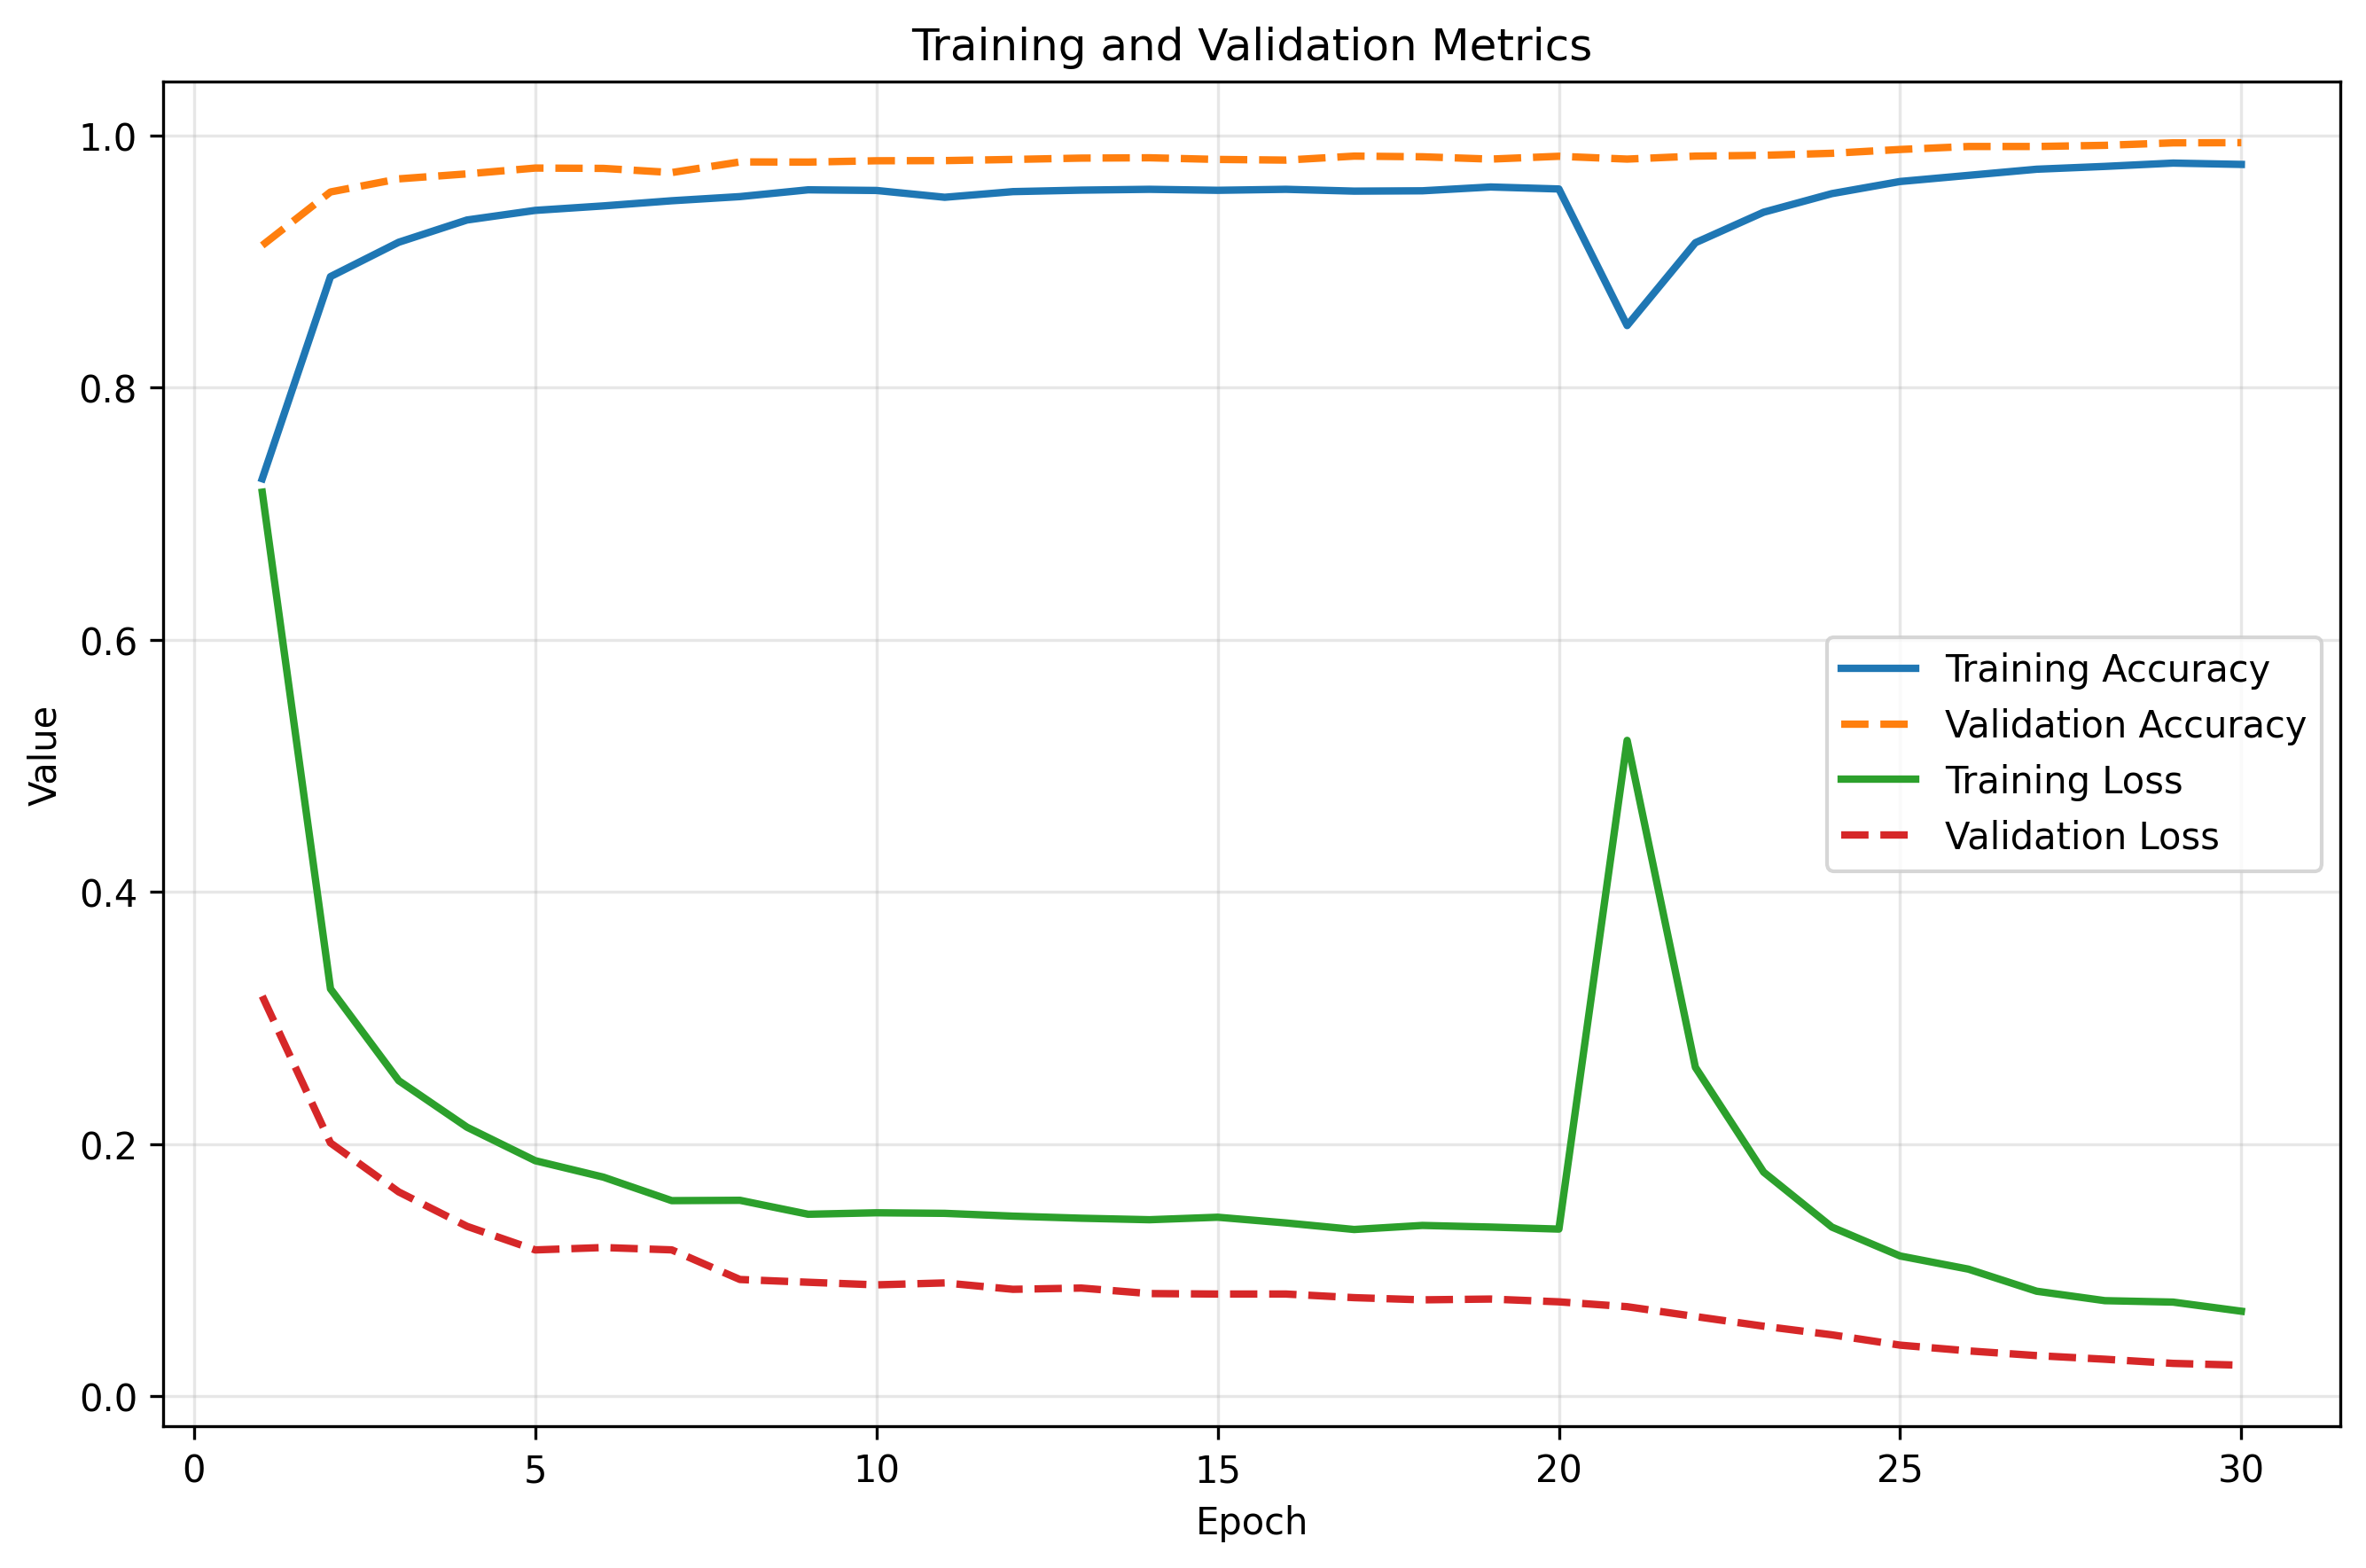

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(9, 6), dpi=300)

plt.plot(epochs, hist["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy", linewidth=2, linestyle="--")
plt.plot(epochs, hist["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation Loss", linewidth=2, linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training and Validation Metrics")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_all_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_all_metrics.pdf", bbox_inches="tight")
plt.show()


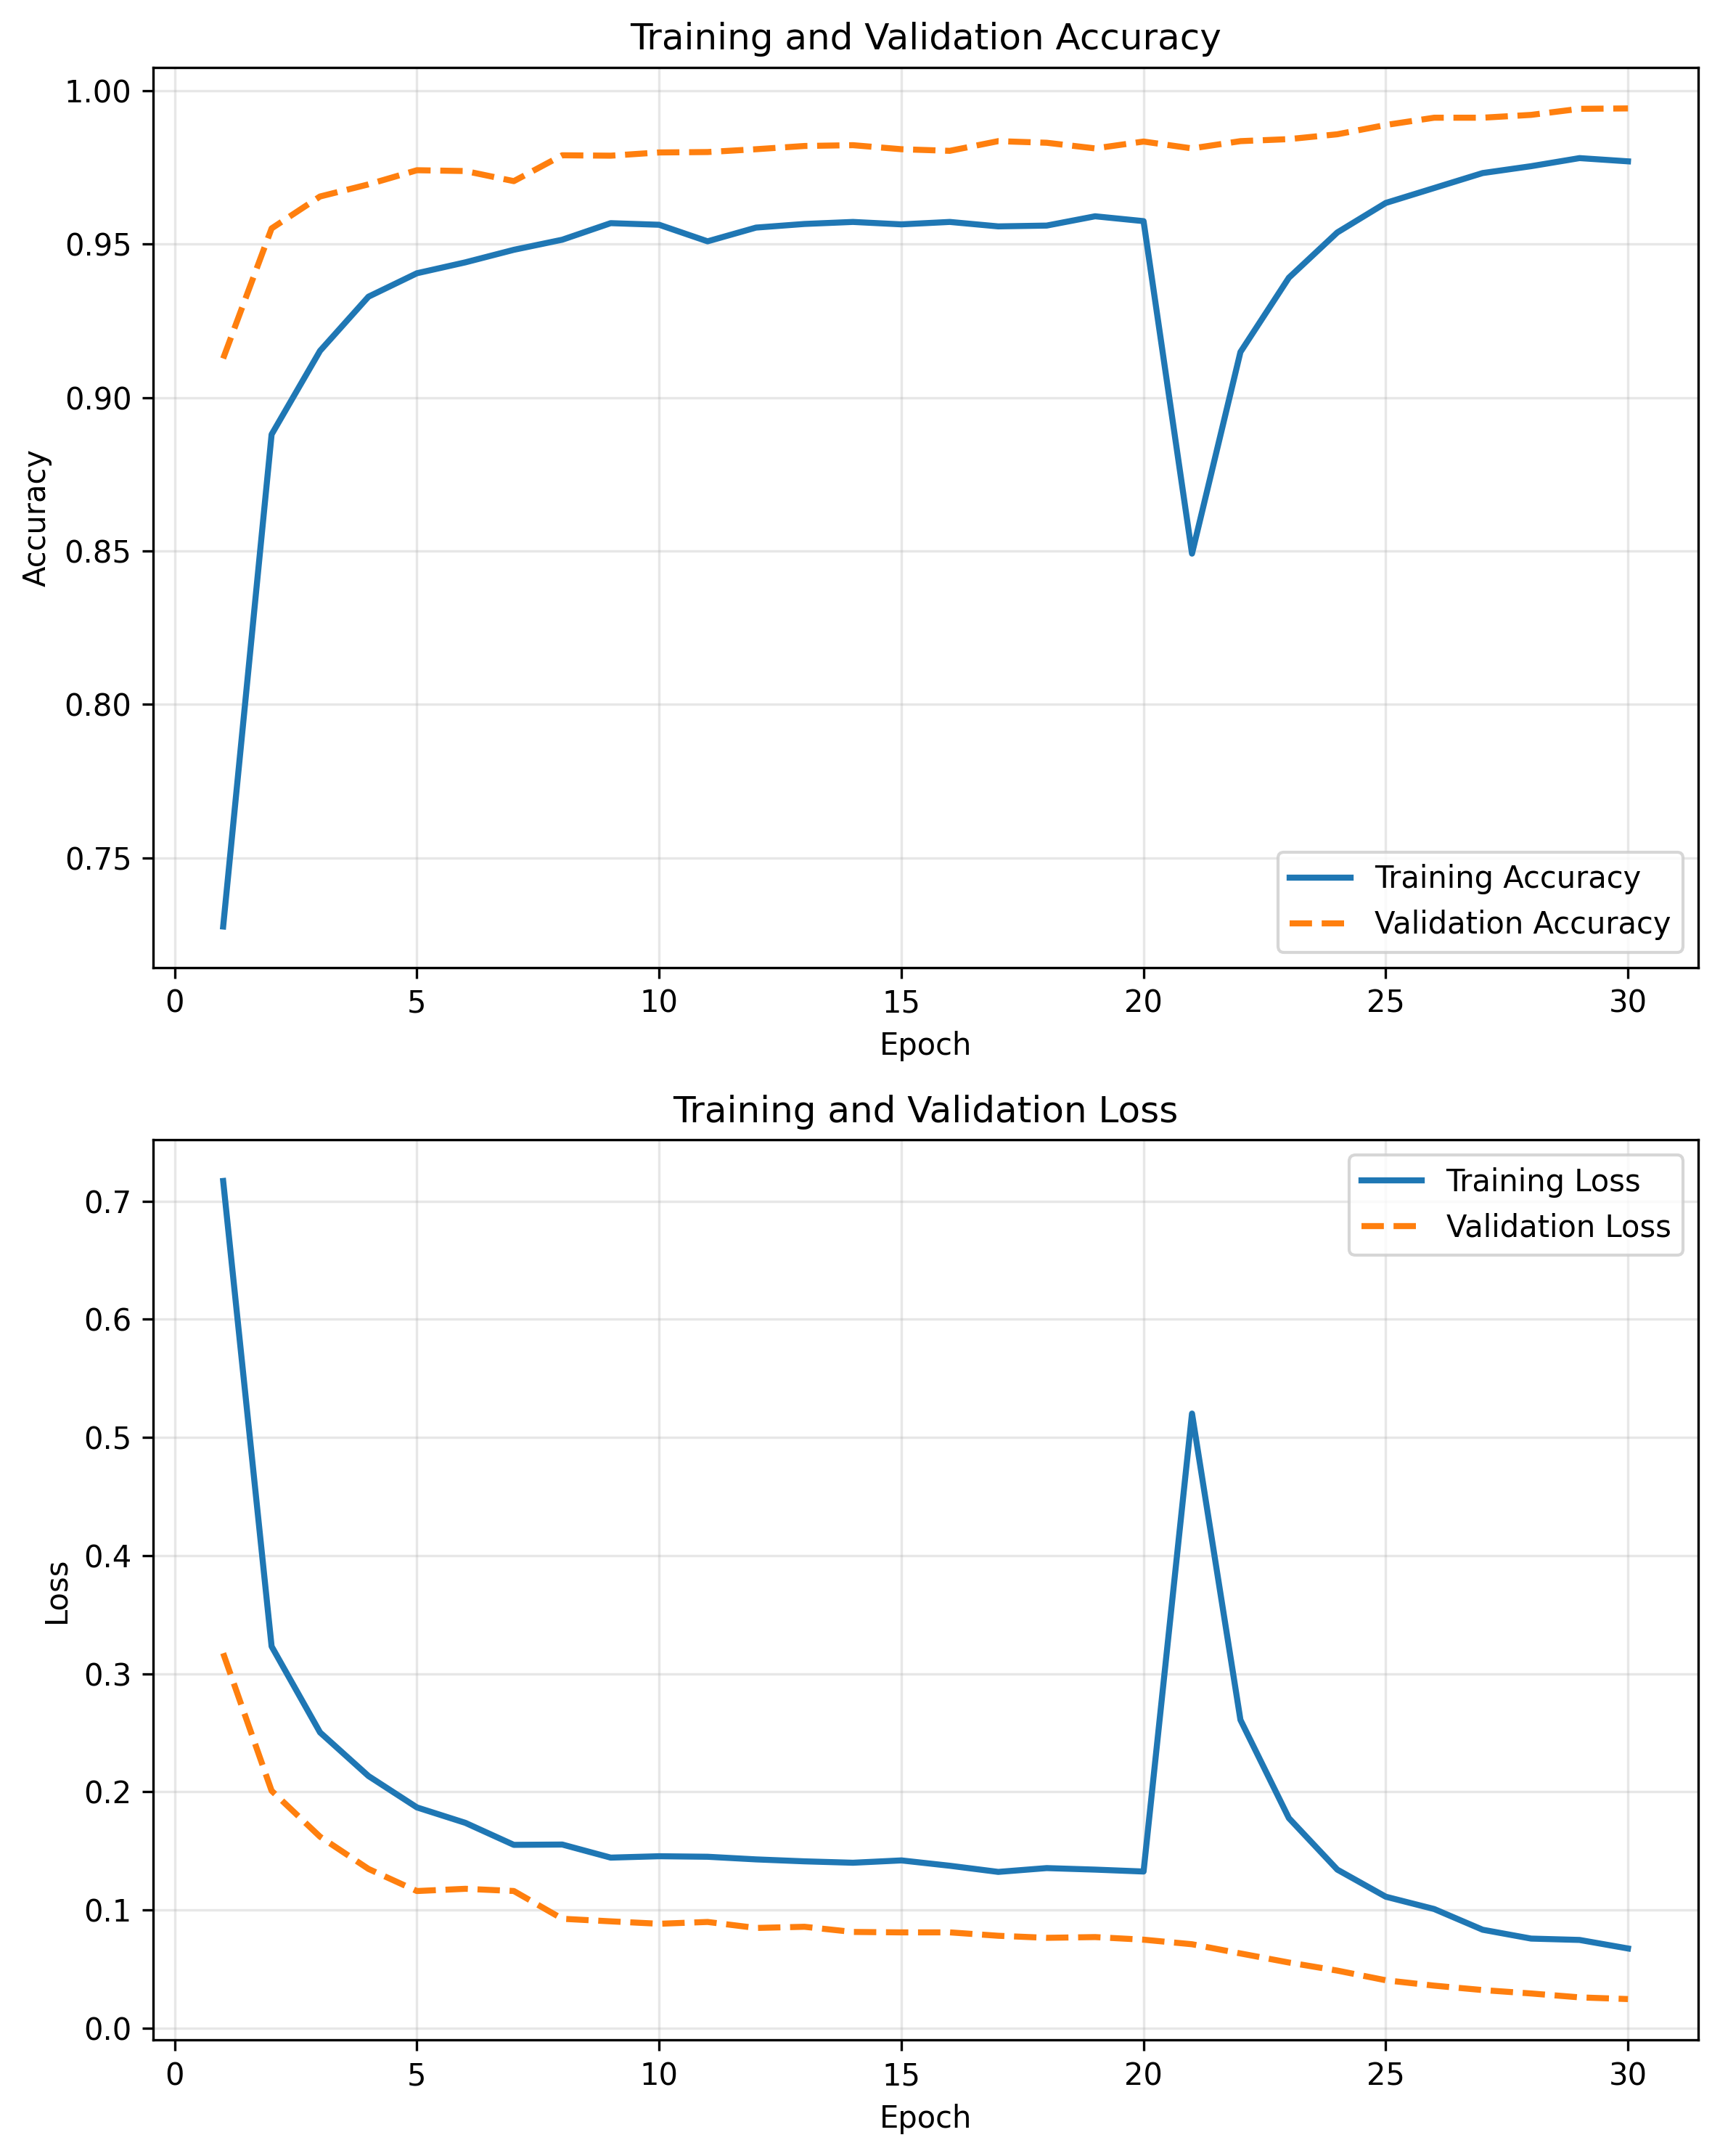

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, len(hist["accuracy"]) + 1)

plt.figure(figsize=(8, 10), dpi=300)

# -------- Accuracy --------
plt.subplot(2, 1, 1)
plt.plot(epochs, hist["accuracy"], label="Training Accuracy", linewidth=2)
plt.plot(epochs, hist["val_accuracy"], label="Validation Accuracy", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)

# -------- Loss --------
plt.subplot(2, 1, 2)
plt.plot(epochs, hist["loss"], label="Training Loss", linewidth=2)
plt.plot(epochs, hist["val_loss"], label="Validation Loss", linewidth=2, linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_validation_metrics.png", dpi=300, bbox_inches="tight")
plt.savefig("training_validation_metrics.pdf", bbox_inches="tight")
plt.show()
